<a href="https://colab.research.google.com/github/Sounak97/Assignment-5/blob/Sounak97/synthetic_features_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Synthetic Features and Outliers
Learning Objectives:

Create a synthetic feature that is the ratio of two other features
Use this new feature as an input to a linear regression model
Improve the effectiveness of the model by identifying and clipping (removing) outliers out of the input data


In [1]:
#revisiting our california housing dataframe
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
4642,-118.1,34.1,32.0,4275.0,1061.0,2812.0,1012.0,3.4,214.1
1783,-117.3,34.1,39.0,3521.0,747.0,2256.0,721.0,2.1,87.5
1275,-117.1,32.7,44.0,658.0,218.0,869.0,212.0,1.9,89.4
10044,-119.8,36.8,19.0,1524.0,448.0,960.0,386.0,1.5,47.5
14696,-122.2,37.5,37.0,2848.0,328.0,852.0,327.0,13.4,500.0
...,...,...,...,...,...,...,...,...,...
16505,-122.6,38.2,31.0,2554.0,515.0,1507.0,533.0,3.8,162.6
13541,-122.0,38.3,11.0,1500.0,319.0,899.0,304.0,4.6,127.2
10112,-119.8,36.8,9.0,2340.0,544.0,860.0,520.0,3.3,119.3
4797,-118.1,34.1,31.0,1146.0,289.0,1163.0,258.0,2.2,185.6


In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')

  # Create input functions.
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Create a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
  return calibration_data

All functions and models from the previous exercise have been drawn

Task 1: Trying a Synthetic Feature
Both the total_rooms and population features count totals for a given city block.

But what if one city block were more densely populated than another? We can explore how block density relates to median house value by creating a synthetic feature that's a ratio of total_rooms and population.

In the cell below, create a feature called rooms_per_person, and use that as the input_feature to train_model().

What's the best performance you can get with this single feature by tweaking the learning rate? (The better the performance, the better your regression line should fit the data, and the lower the final RMSE should be.)



Training model...
RMSE (on training data):
  period 00 : 212.74
  period 01 : 189.64
  period 02 : 170.03
  period 03 : 152.51
  period 04 : 141.01
  period 05 : 133.56
  period 06 : 131.06
  period 07 : 130.66
  period 08 : 130.72
  period 09 : 131.39
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,194.8,207.3
std,89.1,116.0
min,45.3,15.0
25%,159.8,119.4
50%,191.8,180.4
75%,218.9,265.0
max,4250.8,500.0


Final RMSE (on training data): 131.39


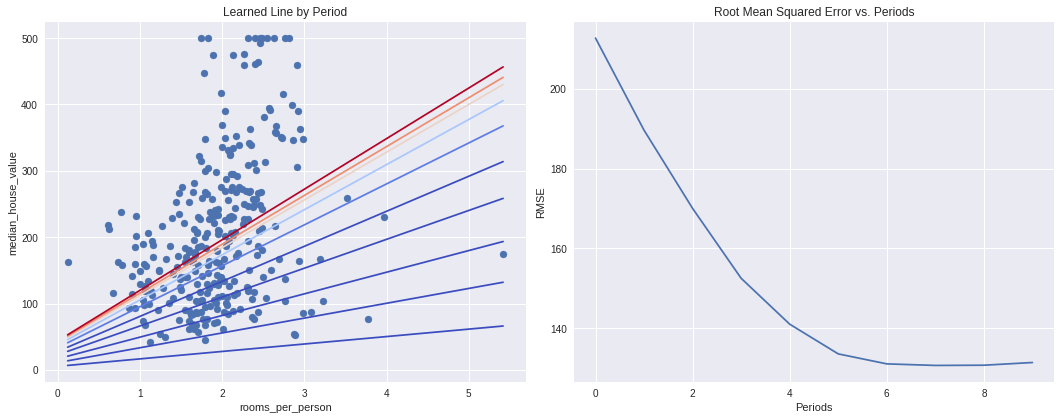

In [5]:
california_housing_dataframe['rooms_per_person']=(california_housing_dataframe['total_rooms']/california_housing_dataframe['population'])
calibration_data=train_model(learning_rate=0.05,steps=500,batch_size=5,input_feature="rooms_per_person")

Task 2: Identifying Outliers
We can visualize the performance of our model by creating a scatter plot of predictions vs. target values. Ideally, these would lie on a perfectly correlated diagonal line.

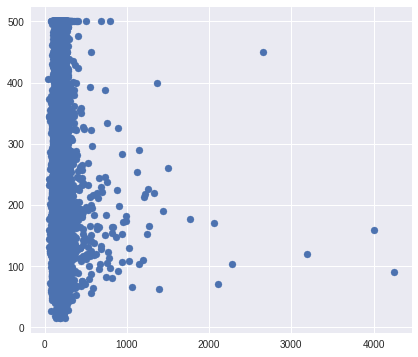

In [6]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(calibration_data['predictions'],calibration_data['targets'])

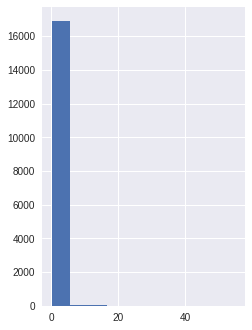

In [7]:
plt.subplot(1,2,2)
_=california_housing_dataframe["rooms_per_person"].hist()#histogram

Task 3: Clip Outliers
See if you can further improve the model fit by setting the outlier values of rooms_per_person to some reasonable minimum or maximum.

For reference, here's a quick example of how to apply a function to a Pandas Series:

clipped_feature = my_dataframe["my_feature_name"].apply(lambda x: max(x, 0))
The above clipped_feature will have no values less than 0.

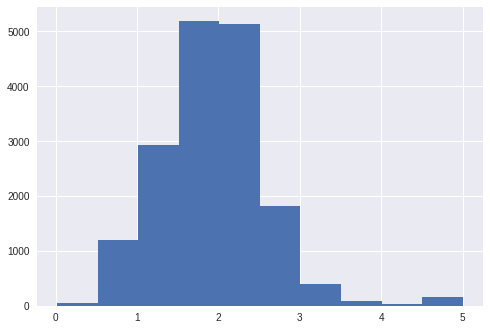

In [8]:
#in the derives histogram values are mostly less than 5
#trying to clip rooms_per_person to less than 5 and recheck wi tanother histogram
california_housing_dataframe["rooms_per_person"]=(california_housing_dataframe["rooms_per_person"]).apply(lambda x:min(x,5))
_=california_housing_dataframe["rooms_per_person"].hist()

Training model...
RMSE (on training data):
  period 00 : 108.13
  period 01 : 109.25
  period 02 : 107.87
  period 03 : 108.42
  period 04 : 108.00
  period 05 : 107.95
  period 06 : 107.90
  period 07 : 110.40
  period 08 : 110.37
  period 09 : 107.72
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,200.7,207.3
std,50.2,116.0
min,53.4,15.0
25%,168.6,119.4
50%,200.8,180.4
75%,228.1,265.0
max,435.2,500.0


Final RMSE (on training data): 107.72


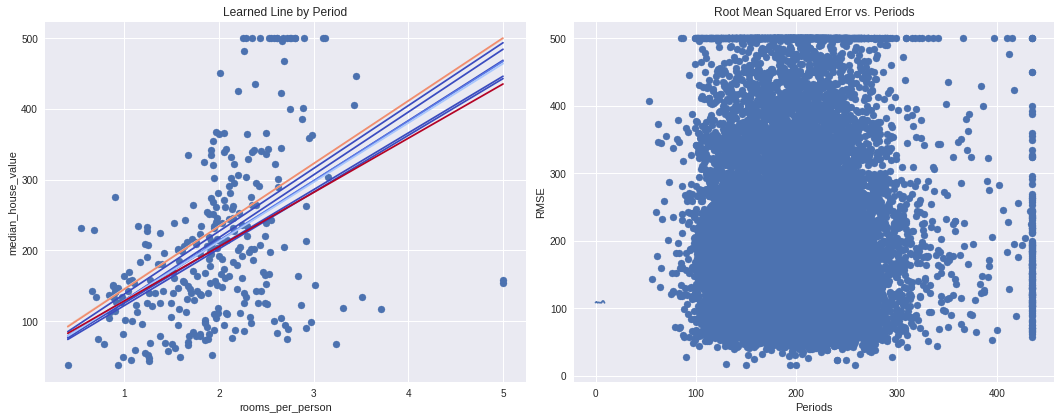

In [12]:
#printing the calibration data
calibration_data=train_model(learning_rate=0.5,steps=500,batch_size=5,input_feature="rooms_per_person")
_=plt.scatter(calibration_data['predictions'],calibration_data['targets'])